In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, auc
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import LabelBinarizer

In [2]:
data = pd.read_excel("Source Data 4 The source data for Figure 4 in manuscript.xlsx")

In [20]:
def get_x_y(data, target_variable_name, use_target_features):
    target = data[target_variable_name]
    if use_target_features:
        features = data[data.columns[:21]].drop(target_variable_name, axis=1)
    else:
        features = data[data.columns[:18]]
    return features, target

def plot_feature_importance(data, target_variable_name, use_target_features, var_name_mapping):
    features, target = get_x_y(data, target_variable_name, use_target_features)
    features = features.rename(var_name_mapping, axis=1)
    clf = RandomForestClassifier(n_estimators=20, random_state=42)
    clf.fit(features, target)
    importances = clf.feature_importances_
    features_names = features.columns
    indices = np.argsort(importances)[::-1]
    features_names = [features_names[i] for i in indices]
    importances = [importances[i] for i in indices]
    
    out = "" if use_target_features else "out"
    plt.figure(figsize=(10, 6))
    plt.title(f"Feature importances")
    plt.bar(range(features.shape[1]), importances, color="r", align="center")
    plt.xticks(range(features.shape[1]), features_names, rotation='vertical')
    plt.xlim([-1, features.shape[1]])
    plt.show()

def plot_roc_curves(data, target_variable_name):
    features, target = get_x_y(data, target_variable_name, use_target_features=False)
    skf = KFold(n_splits=5, shuffle=True, random_state=42)
    accuracies = []
    
    X = features.values
    y = target.values

    clf = RandomForestClassifier(n_estimators=20, random_state=42)
    clf.fit(X, y)

    lb = LabelBinarizer()
    lb.fit(y)
    
    l_one_hot = lb.transform(y)
    
    y_score = clf.predict_proba(X)
    
    for i in range(10):
        fpr, tpr, _ = roc_curve(l_one_hot[:, i], y_score[:, i])
        auc_score = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"R{i+1} AUC={auc_score:.2f}")
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel("False Positive Rate", size=13)
    plt.ylabel("True Positive Rate", size=13)
    plt.legend()
    plt.show()

def get_cv_accuracies(features, target, train_on_test_data, n_folds, random_state=None, clf_hparams=None):
    if random_state is None:
        random_state = 42
    if clf_hparams is None:
        clf_hparams = dict()
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=random_state)
    X = features.values
    y = target.values
    accuracies = []
    if train_on_test_data:
        clf = RandomForestClassifier(random_state=42, **clf_hparams)
        clf.fit(X, y)
    
    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        if not train_on_test_data:
            clf = RandomForestClassifier(random_state=42, **clf_hparams)
            clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        accuracies.append(accuracy_score(y_test, y_pred))
    return accuracies

def get_avg_auc_score(data, target_variable_name, train_on_test_data, n_folds, clf_hparams):
    features, target = get_x_y(data, target_variable_name, use_target_features=False)
    kf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
    X = features.values
    y = target.values
    lb = LabelBinarizer()
    lb.fit(y)
    
    auc_scores = []
    if train_on_test_data:
        for random_state in [42, 43, 44, 45, 46]:
            clf = RandomForestClassifier(random_state=random_state, **clf_hparams)
            clf.fit(X, y)
            y_score = clf.predict_proba(X)
            y_test_bin = lb.transform(y)

            per_class_auc = []
            for i in range(10):
                fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
                per_class_auc.append(auc(fpr, tpr))
            auc_scores.append(np.mean(per_class_auc))
        return np.mean(auc_scores), np.std(auc_scores)
    else:
        for train_index, test_index in kf.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            clf = RandomForestClassifier(n_estimators=20, random_state=42)
            clf.fit(X_train, y_train)
            y_score = clf.predict_proba(X_test)
            y_test_bin = lb.transform(y_test)

            per_class_auc = []
            for i in range(10):
                fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
                per_class_auc.append(auc(fpr, tpr))
            auc_scores.append(np.mean(per_class_auc))

        return np.mean(auc_scores), np.std(auc_scores)

import matplotlib.patches as patches
def plot_accuracies(data, target_names, train_on_test_data, n_folds, random_state, clf_hparams):
    if clf_hparams is None:
        clf_hparams = dict()
    fig, ax = plt.subplots()
    for target_name in target_names:
        features, target = get_x_y(data, target_name, use_target_features=False)
        accuracies = get_cv_accuracies(features, target, train_on_test_data, n_folds, random_state, clf_hparams)
        max_val = np.max(accuracies)
        max_ind = np.argmax(accuracies)
        ax.plot(np.arange(1, n_folds + 1), accuracies, label=target_name)
        if target_name == 'rank-kmeans':
            W = 0.2
            ellipse = patches.Ellipse((max_ind + 1, max_val), width=W, height=0.12 * W, edgecolor='r', facecolor='none')
            ax.add_patch(ellipse)
            ax.text(max_ind + 1.1, max_val, f'{100 * max_val:.2f}%', fontsize=10)
        ax.set_ylim((0.1, 0.9))
        ax.legend()
        print(f'Average Accuracy for {target_name}: {100 * np.mean(accuracies):.2f}±{100 * np.std(accuracies):.2f}%')
    ax.legend()

In [21]:
var_name_mapping = {
    'Latitude': 'Latitude',
    'Ultraviolet radiation': 'UV',
    'Sea level rise': 'SLR',
    'Demersal non-habitat modifying, low-bycatch fishing': 'DNL',
    'Ocean pollution': 'OP',
    'Surface temperature': 'STR',
    'Pelagic, low-bycatch fishing': 'PL',
    'Demersal non-habitat modifying, high-bycatch fishing': 'DNH',
    'Ocean acidification': 'OA',
    'Shipping': 'Shipping',
    'Stable lights at night': 'SLN',
    'Pelagic, high-bycatch fishing': 'PH',
    'Inorganic pollution': 'IP',
    'Fertilizers pollution (nutrients)': 'FP',
    'Pesticides pollution (organic)': 'PP',
    'Oil rigs': 'OR',
    'Artisanal fishing': 'Fishing',
    'Invasive species': 'IS'
}

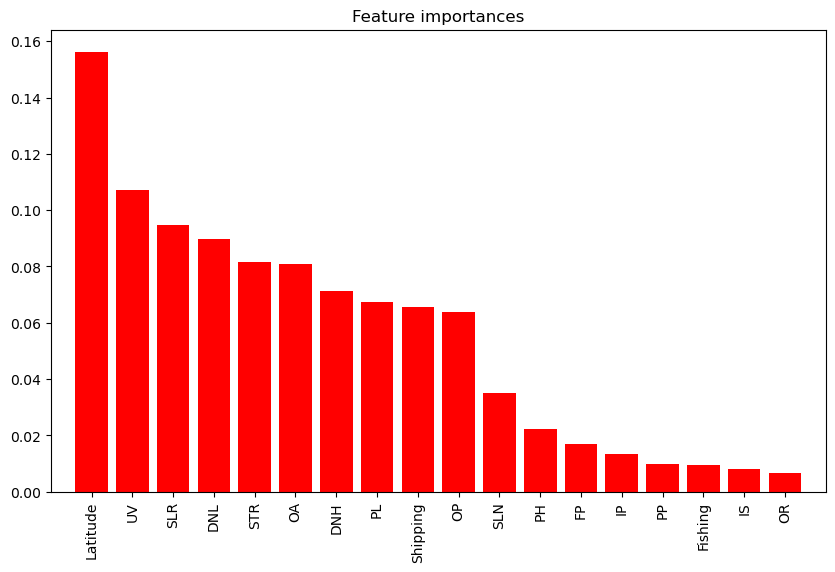

In [22]:
plot_feature_importance(data, 'rank-kmeans', use_target_features=False, var_name_mapping=var_name_mapping)

In [23]:
def plot_feature_importance_h(data, target_variable_name, use_target_features, var_name_mapping):
    features, target = get_x_y(data, target_variable_name, use_target_features)
    features = features.rename(var_name_mapping, axis=1)
    clf = RandomForestClassifier(n_estimators=20, random_state=42)
    clf.fit(features, target)
    importances = clf.feature_importances_
    features_names = features.columns
    indices = np.argsort(importances)[::-1]
    features_names = [features_names[i] for i in indices]
    importances = [importances[i] for i in indices]
    
    out = "" if use_target_features else "out"
    plt.figure(figsize=(6, 10))
    plt.title(f"Feature importances")
    plt.barh(range(features.shape[1]), importances, color="r", align="center")
    plt.yticks(range(features.shape[1]), features_names, rotation='horizontal')
    plt.ylim([-1, features.shape[1]])
    plt.show()

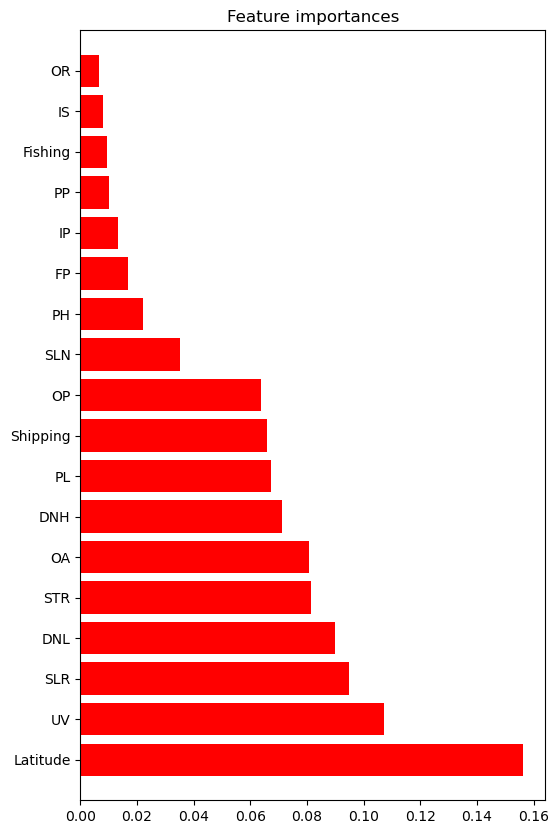

In [24]:
plot_feature_importance_h(data, 'rank-kmeans', use_target_features=False, var_name_mapping=var_name_mapping)

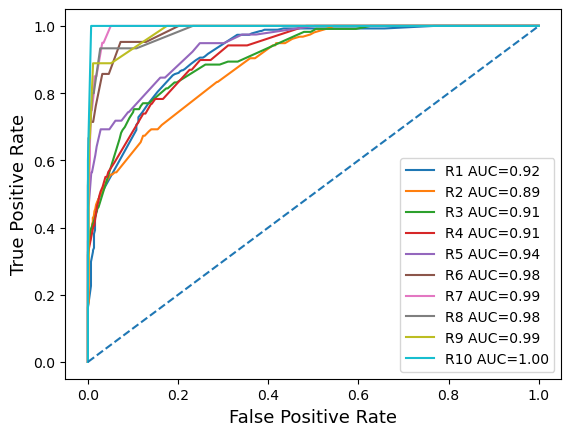

In [25]:
plot_roc_curves(data, 'rank-kmeans')

Average Accuracy for rank-kmeans: 36.39±5.13%
Average Accuracy for rank-equalfrequency: 18.68±4.37%


Text(0.5, 0, 'Round')

<Figure size 600x600 with 0 Axes>

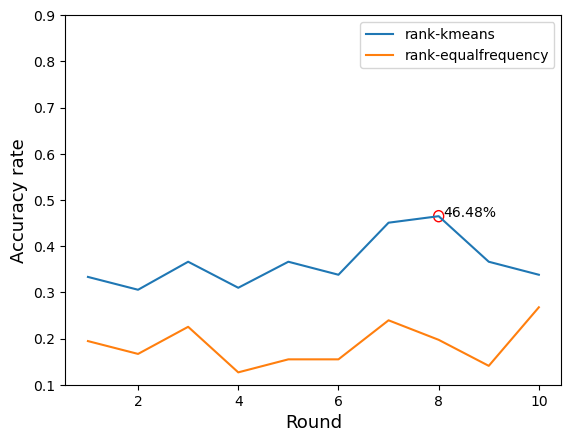

In [27]:
plt.figure(figsize=(6, 6))
plot_accuracies(data, ['rank-kmeans', 'rank-equalfrequency'], train_on_test_data=False, n_folds=10,
                random_state=42, clf_hparams={'n_estimators':20})
plt.ylabel("Accuracy rate", size=13)
plt.xlabel("Round", size=13)

In [28]:
import math

In [34]:
1 / math.factorial(10)

2.755731922398589e-07

In [277]:
get_avg_auc_score(data, 'rank-kmeans', train_on_test_data=True, n_folds=5)

(0.950909430210283, 7.263282680745736e-05)

In [278]:
f"{0.9509423762741369:.2f}±{7.263282680745736e-05:.2f}"

'0.95±0.00'

In [274]:
get_avg_auc_score(data, 'rank-kmeans', train_on_test_data=False, n_folds=5)

(0.6418578491549913, 0.04058564108499076)

In [279]:
f"{0.6418578491549913:.2f}±{0.04058564108499076:.2f}"

'0.64±0.04'

### Max accuracy

In [287]:
def get_max_accuracies(data, train_on_test_data, n_folds):
    features, target = get_x_y(data, 'rank-kmeans', use_target_features=False)
    max_accuracies = []
    for random_state in [42, 43, 44, 45, 46]:
        max_accuracies.append(np.max(get_cv_accuracies(features, target, train_on_test_data, n_folds, random_state=random_state)))
    return max_accuracies

In [289]:
max_accuracies = get_max_accuracies(data, train_on_test_data=False, n_folds=10)

In [290]:
f'Average Accuracy for NDL: {100 * np.mean(max_accuracies):.2f}±{100 * np.std(max_accuracies):.2f}%'

'Average Accuracy for NDL: 46.34±2.38%'

In [291]:
max_accuracies = get_max_accuracies(data, train_on_test_data=True, n_folds=10)

In [292]:
f'Average Accuracy for NDL: {100 * np.mean(max_accuracies):.2f}±{100 * np.std(max_accuracies):.2f}%'

'Average Accuracy for NDL: 76.42±3.40%'

In [ ]:
np.mean(max_accuracies), 

### Variable importance stability

In [ ]:
data.rename

In [35]:
def plot_feature_importance_w_error_bars(data, target_variable_name, n_folds=5, var_name_mapping=None):
    features, target = get_x_y(data, target_variable_name, use_target_features=False)
    features = features.rename(var_name_mapping, axis=1)
    features_names = features.columns
    kf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
    X = features.values
    y = target.values
    all_importances = []
    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        clf = RandomForestClassifier(n_estimators=20, random_state=42)
        clf.fit(X_train, y_train)
        all_importances.append(clf.feature_importances_)
    total_importances = RandomForestClassifier(n_estimators=20, random_state=42).fit(X, y).feature_importances_
    importances_means = np.mean(np.array(all_importances), axis=0).tolist()
    importances_std = np.std(np.array(all_importances), axis=0).tolist()
    features_names = features.columns
    indices = np.argsort(importances_means)[::-1]
    features_names = [features_names[i] for i in indices]
    importances_means = [importances_means[i] for i in indices]
    importances_std = [importances_std[i] for i in indices]
    total_importances = [total_importances[i] for i in indices]
    plt.figure(figsize=(10, 6))
    plt.title(f"Feature importances for predicting antibiotic resistance")
    plt.bar(np.array(range(features.shape[1])) - 0.2, importances_means, width=0.4, yerr=importances_std, color="lightcoral", align="center", label='CV')
    plt.bar(np.array(range(features.shape[1])) + 0.2, total_importances, width=0.4, color="lightblue", align="center", label='Full dataset')
    plt.xticks(range(features.shape[1]), features_names, rotation='vertical')
    plt.legend()
    plt.xlim([-1, features.shape[1]])
    plt.show()

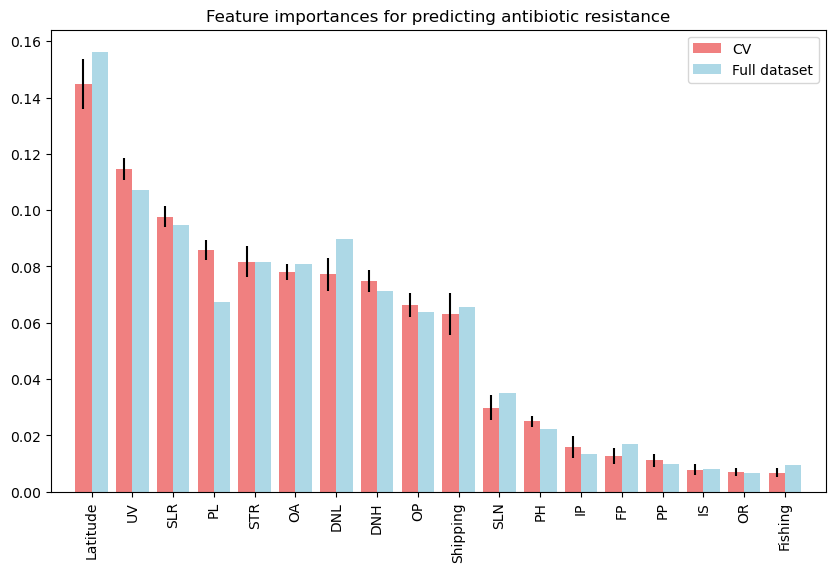

In [36]:
plot_feature_importance_w_error_bars(data, 'rank-kmeans', n_folds=5, var_name_mapping=var_name_mapping)

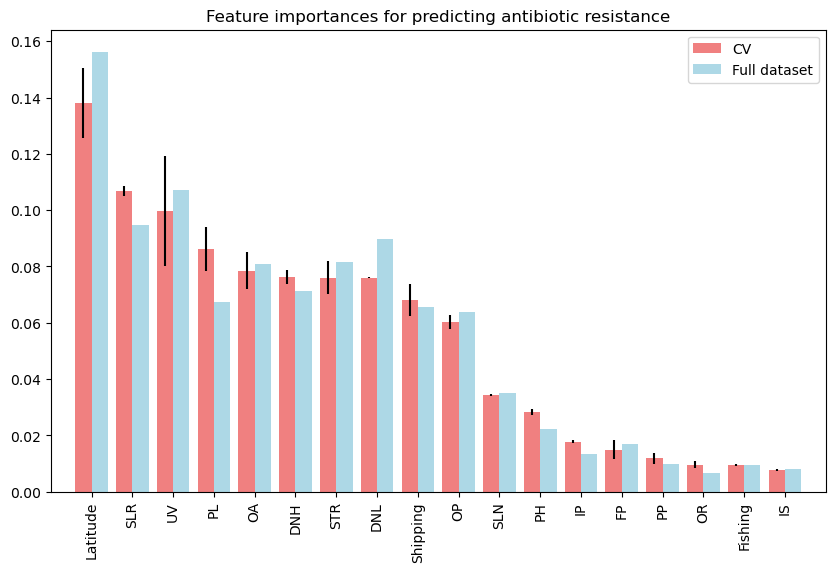

In [40]:
plot_feature_importance_w_error_bars(data, 'rank-kmeans', n_folds=2, var_name_mapping=var_name_mapping)

In [298]:
data.columns

Index(['Latitude', 'Ultraviolet radiation', 'Surface temperature',
       'Sea level rise', 'Shipping', 'Pelagic, low-bycatch fishing',
       'Pelagic, high-bycatch fishing', 'Ocean pollution',
       'Ocean acidification', 'Invasive species',
       'Demersal non-habitat modifying, low-bycatch fishing',
       'Demersal non-habitat modifying, high-bycatch fishing',
       'Artisanal fishing', 'Oil rigs', 'Pesticides pollution (organic)',
       'Stable lights at night', 'Fertilizers pollution (nutrients)',
       'Inorganic pollution', 'rank-kmeans', 'rank-equalwidth',
       'rank-equalfrequency', 'Unnamed: 21',
       'All the results for machine learning were based on this data.'],
      dtype='object')

## Error analysis

In [51]:
from sklearn.metrics import confusion_matrix

In [45]:
features, target = get_x_y(data, 'rank-kmeans', use_target_features=False)

In [69]:
from sklearn.preprocessing import OneHotEncoder

In [102]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=424)
X = features.values
y = target.values
one_hot_encoder = OneHotEncoder()
one_hot_encoder.fit(y[:, np.newaxis])
all_preds = []
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf = RandomForestClassifier(n_estimators=20, random_state=42)
    clf.fit(X_train, y_train)
    y_preds = clf.predict(X_test)
    all_preds.append(np.mean(one_hot_encoder.transform(y_preds[:, np.newaxis]).todense(), axis=0))

In [106]:
all_preds = np.row_stack(all_preds)

In [125]:
all_preds_mean = np.mean(all_preds, axis=0)

In [108]:
all_preds_std = np.std(all_preds, axis=0)

In [114]:
true_hist = dict(target.value_counts())

In [116]:
true_hist = {
    key: val / sum(true_hist.values())
    for key, val in true_hist.items()
}

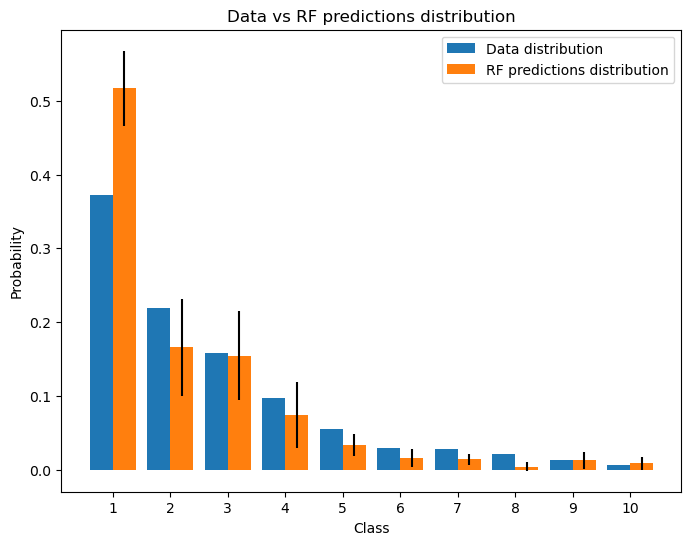

In [147]:
plt.figure(figsize=(8, 6))
plt.bar(np.arange(10) - 0.2, [true_hist[i] for i in range(1, 11)], width=0.4, label='Data distribution')
plt.bar(np.arange(10) + 0.2, np.array(all_preds_mean)[0].tolist(), yerr=np.array(all_preds_std)[0].tolist(),
        width=0.4, label='RF predictions distribution')
plt.legend()
plt.title('Data vs RF predictions distribution')
plt.xlabel('Class')
plt.ylabel('Probability')
_ = plt.xticks(np.arange(10), [str(i + 1) for i in range(10)])

In [64]:
cm = confusion_matrix(y_test, y_preds)

In [65]:
labels = [str(i + 1) for i in range(10)]

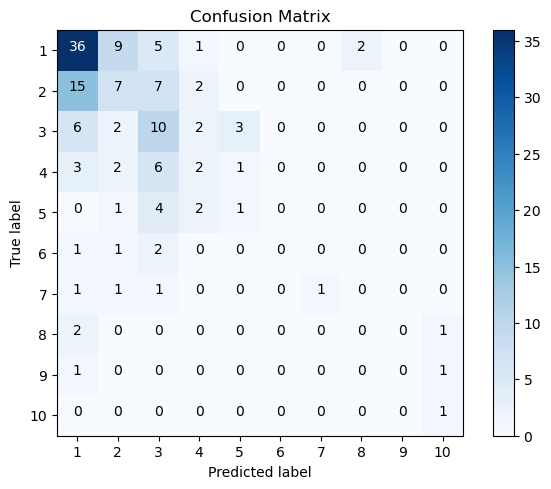

In [66]:
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels)
plt.yticks(tick_marks, labels)

thresh = cm.max() / 2.0
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [151]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=424)
X = features.values
y = target.values
majority_class_accuracy = []
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    majority_class_accuracy.append(np.mean(y_test == 1))

In [153]:
np.mean(majority_class_accuracy)

0.3721954102235792

In [267]:
print(f'Average Accuracy: {100 * np.mean(majority_class_accuracy):.2f}±{100 * np.std(majority_class_accuracy):.2f}%')

Average Accuracy: 37.22±0.13%


In [294]:
max_accuracies = []
for random_state in [42, 43, 44, 45, 56]:
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    X = features.values
    y = target.values
    majority_class_accuracy = []
    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        majority_class_accuracy.append(np.mean(y_test == 1))
    max_accuracies.append(np.max(majority_class_accuracy))

In [297]:
100 * np.mean(max_accuracies)

37.32394366197183

In [154]:
from sklearn.ensemble import GradientBoostingClassifier

In [161]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=424)
X = features.values
y = target.values
xgb_accuracies = []
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf = GradientBoostingClassifier(random_state=42)
    clf.fit(X_train, y_train)
    y_preds = clf.predict(X_test)
    xgb_accuracies.append(np.mean(y_preds == y_test))

In [162]:
np.mean(xgb_accuracies)

0.35672215108834826

In [163]:
from sklearn.linear_model import LogisticRegression

In [170]:
LogisticRegression?

In [175]:
from sklearn import preprocessing

In [192]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=424)
X = features.values
y = target.values
logit_accuracies = []
for train_index, test_index in kf.split(X, y):
    scaler = preprocessing.StandardScaler()
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    scaler.fit(X_train)
    clf = LogisticRegression(multi_class='ovr', solver='liblinear')
    clf.fit(scaler.transform(X_train), y_train)
    y_preds = clf.predict(scaler.transform(X_test))
    logit_accuracies.append(np.mean(y_preds == y_test))

In [193]:
np.mean(logit_accuracies)

0.39044617354476513

## Shallower trees

In [262]:
kf = KFold(n_splits=100, shuffle=True, random_state=424)
X = features.values
y = target.values
rf_accuracies = []
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf = RandomForestClassifier(n_estimators=20, random_state=42)
    clf.fit(X_train, y_train)
    y_preds = clf.predict(X_test)
    rf_accuracies.append(np.mean(y_preds == y_test))

In [263]:
np.mean(rf_accuracies), np.std(rf_accuracies)

(0.35035714285714287, 0.18540117836404255)

In [ ]:
### 

In [ ]:
img1.

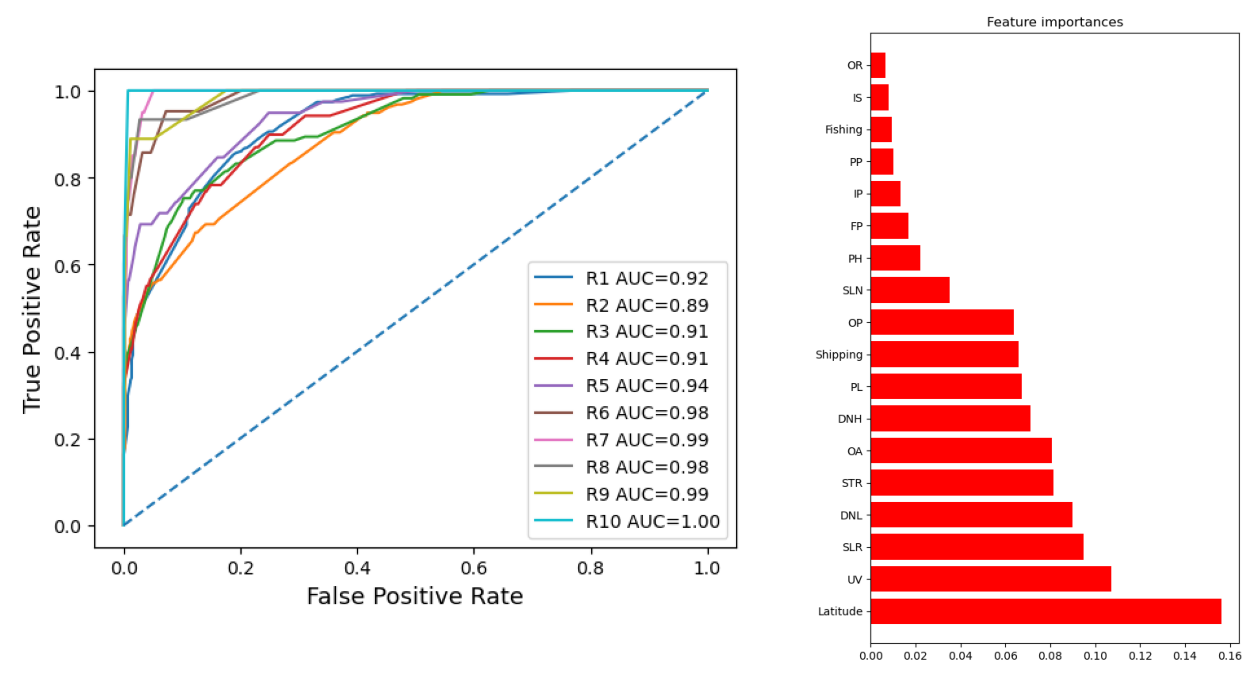

In [331]:
from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=(16, 12))
gs = GridSpec(1, 2, width_ratios=[2, 1.2])

# Create the first subplot
ax1 = fig.add_subplot(gs[0])
ax1.imshow(img1)
ax1.axis('off')
# Create the second subplot
ax2 = fig.add_subplot(gs[1])
ax2.imshow(img2)
ax2.axis('off')
# Adjust the size of the second subplot
gs.update(wspace=0.1)

# Display the plot
plt.show()

In [ ]:
gs = GridSpec(1, 2, width_ratios=[2, 1])

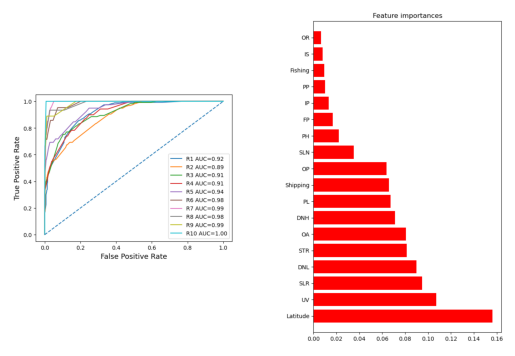

In [319]:
import matplotlib.image as mpimg
img1 = mpimg.imread('/Users/karczer1/Desktop/auc_original.png')
img2 = mpimg.imread('/Users/karczer1/Desktop/feature_importances.png')
plt.subplot(1, 2, 1)

plt.imshow(img1)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(img2)
plt.axis('off')
plt.show()